In [43]:
%pip install prophet statsmodels scikit-learn keras tensorflow matplotlib pandas numpy pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.1/652.1 kB 609.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 398.6 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [49]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [30]:
# Load dataset (replace with actual path to your dataset)
file_path = '/Users/ugyen/Documents/GitHub/Stockex-btn/Dataset/BTCL.csv'
df = pd.read_csv(file_path)

# Preview the data
print(df)

                 DateTime    BTCL
0     2020-04-23 06:34:02  158.45
1     2020-04-23 09:34:02  158.45
2     2020-04-24 06:34:01  158.45
3     2020-04-24 09:34:02  158.45
4     2020-04-27 06:33:57  158.45
...                   ...     ...
5899  2025-04-25 03:56:15  570.00
5900  2025-04-25 04:56:11  570.00
5901  2025-04-25 05:56:18  570.00
5902  2025-04-25 07:56:13  570.00
5903  2025-04-25 08:56:13  570.00

[5904 rows x 2 columns]


In [31]:
# Convert to datetime and extract just the date
df['DateTime'] = pd.to_datetime(df['DateTime']).dt.date

# Keep the last record of each day
daily_df = df.groupby('DateTime').last().reset_index()

# Save the cleaned data
daily_df.to_csv('cleaned_stock_data.csv', index=False)

# Display the cleaned DataFrame and min/max values
print(daily_df)
print("Min value of BTCL stock:", daily_df.min())
print("Max value of BTCL stock:", daily_df.max())


        DateTime    BTCL
0     2020-04-23  158.45
1     2020-04-24  158.45
2     2020-04-27  158.45
3     2020-04-28  158.45
4     2020-04-29  158.45
...          ...     ...
1225  2025-04-21  570.00
1226  2025-04-22  570.00
1227  2025-04-23  570.00
1228  2025-04-24  570.00
1229  2025-04-25  570.00

[1230 rows x 2 columns]
Min value of BTCL stock: DateTime    2020-04-23
BTCL              40.0
dtype: object
Max value of BTCL stock: DateTime    2025-04-25
BTCL           1178.57
dtype: object


In [32]:

# Convert DateTime column to datetime type 
daily_df['DateTime'] = pd.to_datetime(daily_df['DateTime'])

# Create interactive plot
fig = px.line(daily_df, 
              x='DateTime', 
              y='BTCL',
              title='BTCL Price Over Time',
              labels={'BTCL': 'Price (Ngultrum)', 'DateTime': 'Date'},
              template='plotly_white')

# Add customization
fig.update_layout(
    hovermode='y unified',  # Show hover data for all points on x-axis
    xaxis_title='Date',
    yaxis_title='BTCL Price (Ngultrum)',
    
    xaxis_rangeslider_visible=True  # Adds zoom slider at bottom
)

# Add hover data formatting
fig.update_traces(
    hovertemplate='<b>%{x|%Y-%m-%d}</b><br>Price: Nu.%{y:.2f}'
)

# Show the plot
fig.show()

17:48:37 - cmdstanpy - INFO - Chain [1] start processing
17:48:38 - cmdstanpy - INFO - Chain [1] done processing


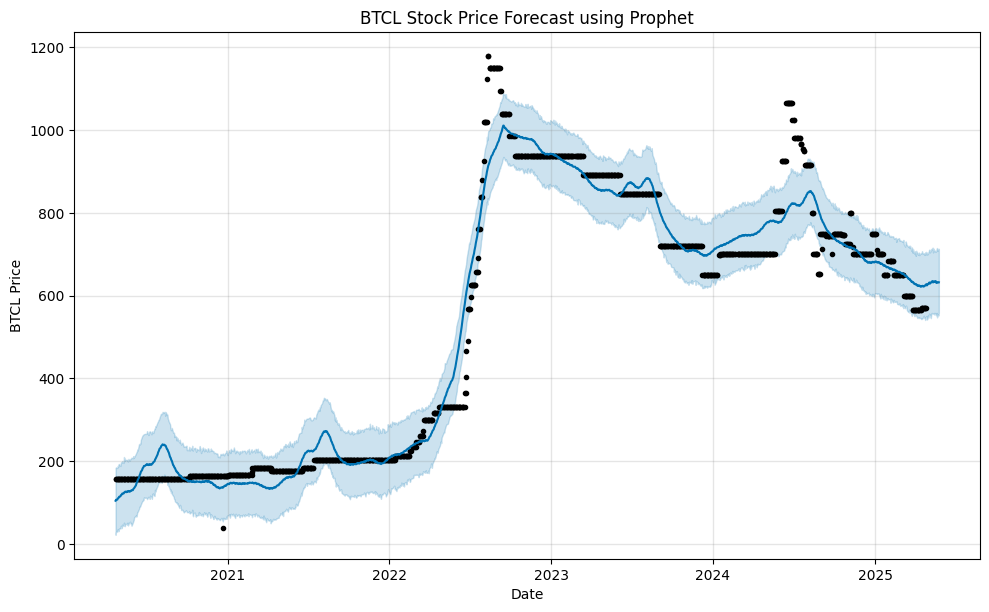

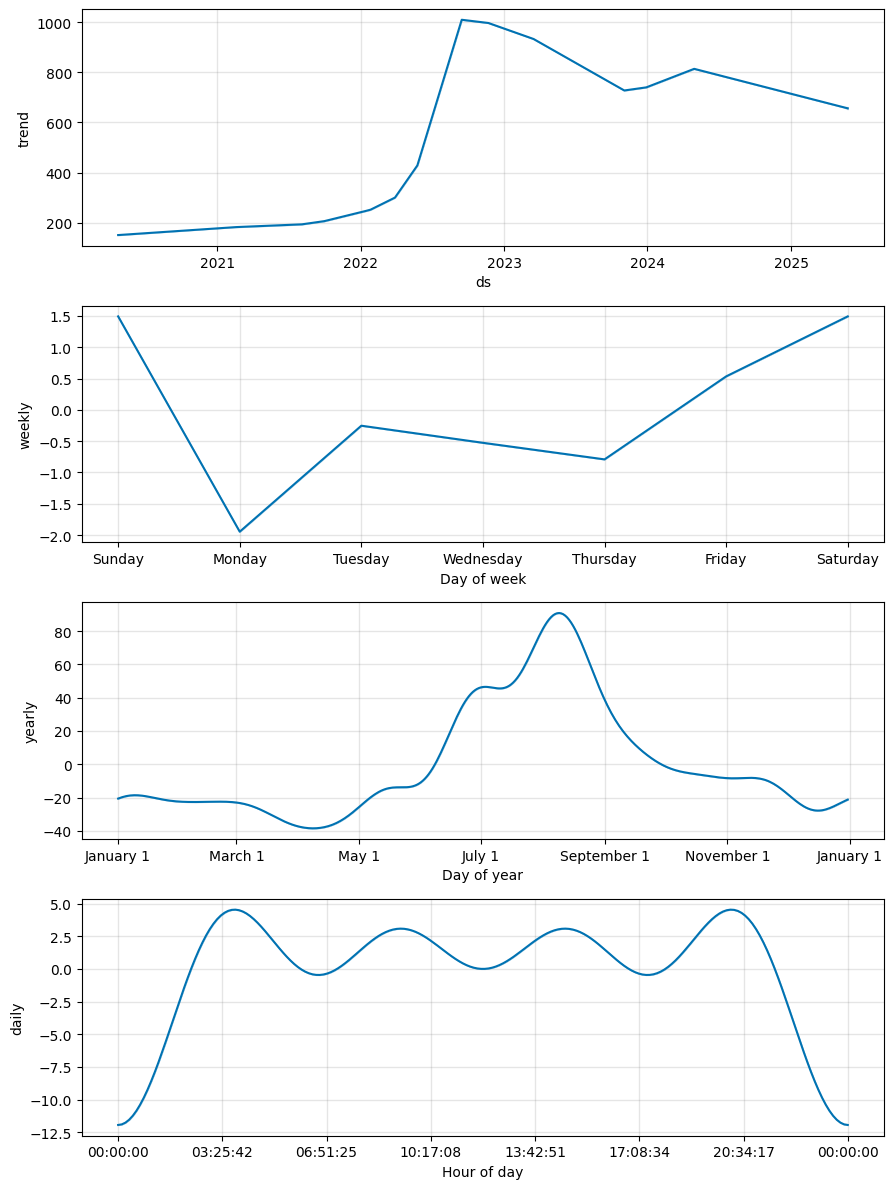

In [19]:
# Prophet expects columns 'ds' for date and 'y' for target
# Create a temporary DataFrame with correct column names for Prophet
prophet_df = pd.DataFrame()
prophet_df['ds'] = daily_df['DateTime']
prophet_df['y'] = daily_df['BTCL']

# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

# Create future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
plt.title("BTCL Stock Price Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("BTCL Price")
plt.grid(True)
plt.show()

# Optional: Plot forecast components (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()

In [20]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))


             ds        yhat  yhat_lower  yhat_upper
1230 2025-04-26  626.954537  549.837061  705.692865
1231 2025-04-27  627.466529  550.758037  698.644053
1232 2025-04-28  624.577027  541.998270  700.687478
1233 2025-04-29  626.853597  543.317456  704.112677
1234 2025-04-30  627.188862  552.047838  699.793334
1235 2025-05-01  627.550401  546.088453  702.741647
1236 2025-05-02  629.511522  550.562334  705.284861
1237 2025-05-03  631.105750  556.463275  710.837452
1238 2025-05-04  631.731298  555.062830  711.173383
1239 2025-05-05  628.897097  550.173339  704.197932
1240 2025-05-06  631.166795  553.326916  706.846264
1241 2025-05-07  631.430196  545.600214  708.147433
1242 2025-05-08  631.653328  555.494191  712.793994
1243 2025-05-09  633.409391  558.297444  712.473533
1244 2025-05-10  634.733353  556.866288  712.250927
1245 2025-05-11  635.026527  557.478009  715.874440
1246 2025-05-12  631.802648  556.600590  704.193572
1247 2025-05-13  633.631882  556.564166  713.620579
1248 2025-05

In [28]:
print(daily_df.columns)


Index(['BTCL', 'ds'], dtype='object')


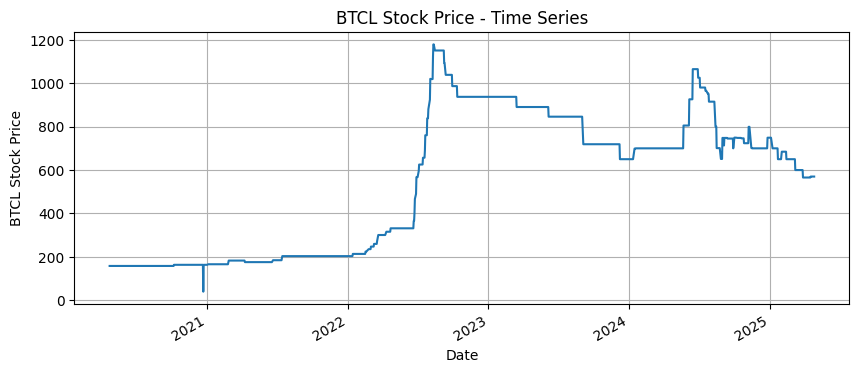


--- ADF Test Results ---
ADF Statistic : -1.5900
p-value       : 0.4886
Critical Values:
   1%: -3.4357
   5%: -2.8639
   10%: -2.5680

❌ The series is NOT stationary (p ≥ 0.05). Differencing is recommended.


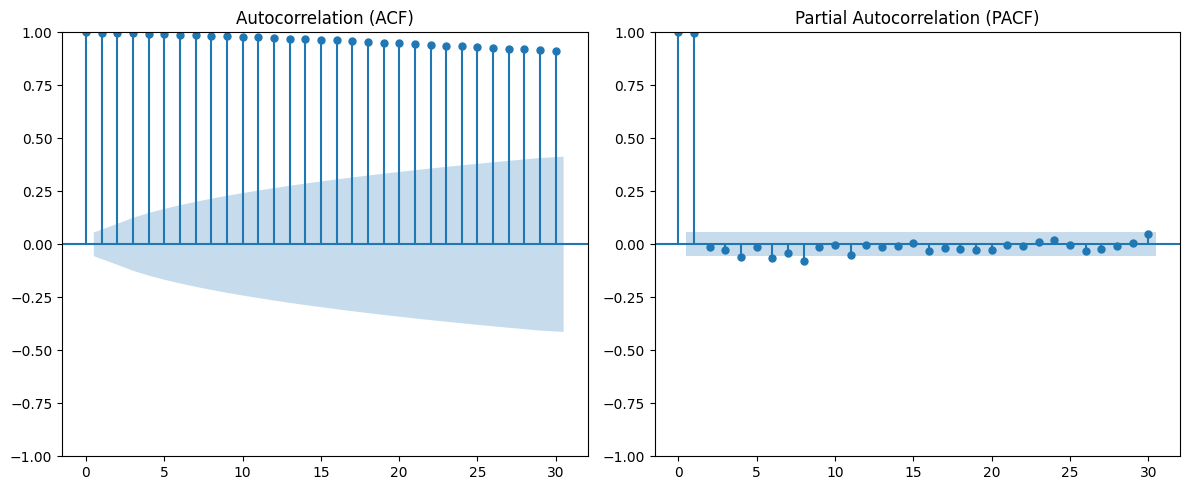

In [33]:
daily_df.set_index('DateTime', inplace=True)

# Optional: Plot the time series
daily_df['BTCL'].plot(title='BTCL Stock Price - Time Series', figsize=(10, 4))
plt.xlabel("Date")
plt.ylabel("BTCL Stock Price")
plt.grid(True)
plt.show()

#Augmented Dickey-Fuller Test for Stationarity
print("\n--- ADF Test Results ---")
adf_result = adfuller(daily_df['BTCL'])

print(f"ADF Statistic : {adf_result[0]:.4f}")
print(f"p-value       : {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print("\n✅ The series is likely stationary (p < 0.05)")
else:
    print("\n❌ The series is NOT stationary (p ≥ 0.05). Differencing is recommended.")

# --- Step 3: Plot ACF and PACF to guide p and q
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(daily_df['BTCL'], ax=plt.gca(), lags=30)
plt.title("Autocorrelation (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(daily_df['BTCL'], ax=plt.gca(), lags=30, method='ywm')
plt.title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()




In [34]:
# First-order differencing
daily_df['BTCL_diff'] = daily_df['BTCL'].diff().dropna()

# Drop the NaN created by differencing
diff_series = daily_df['BTCL_diff'].dropna()


In [36]:
result = adfuller(diff_series)
print('New p-value:', result[1])
if result[1] < 0.05:
    print("The differenced series is stationary (p < 0.05).")
else:
    print("The differenced series is NOT stationary (p ≥ 0.05). Further differencing may be needed.")


New p-value: 2.391482523060112e-16
The differenced series is stationary (p < 0.05).


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensur

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9971.417, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9999.736, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10001.431, Time=0.06 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10001.452, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9998.427, Time=0.07 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9972.825, Time=0.67 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9973.408, Time=0.52 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9970.349, Time=0.90 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9972.061, Time=0.91 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=9972.322, Time=1.79 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9971.876, Time=2.46 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9970.177, Time=0.77 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9971.531, Time=0.61 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=9972.112, Time=1.34 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=9973.527, Time=0.99 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=9973.144, Time=2.50 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,3)(0,0,0)[0]             : AIC=9968.366, Time=0.47 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,3)(0,0,0)[0]             : AIC=9969.726, Time=0.73 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,2)(0,0,0)[0]             : AIC=9969.623, Time=0.67 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,3)(0,0,0)[0]             : AIC=9970.060, Time=0.93 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,4)(0,0,0)[0]             : AIC=9970.302, Time=0.90 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9971.011, Time=0.25 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,4)(0,0,0)[0]             : AIC=9971.721, Time=0.43 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,2)(0,0,0)[0]             : AIC=9968.536, Time=0.43 sec


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,4)(0,0,0)[0]             : AIC=9971.235, Time=1.42 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 21.159 seconds
Best ARIMA order found: (2, 1, 3)


/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/ugyen/anaconda3/envs/r-tensorflow/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/ugyen/anaconda3/envs/r

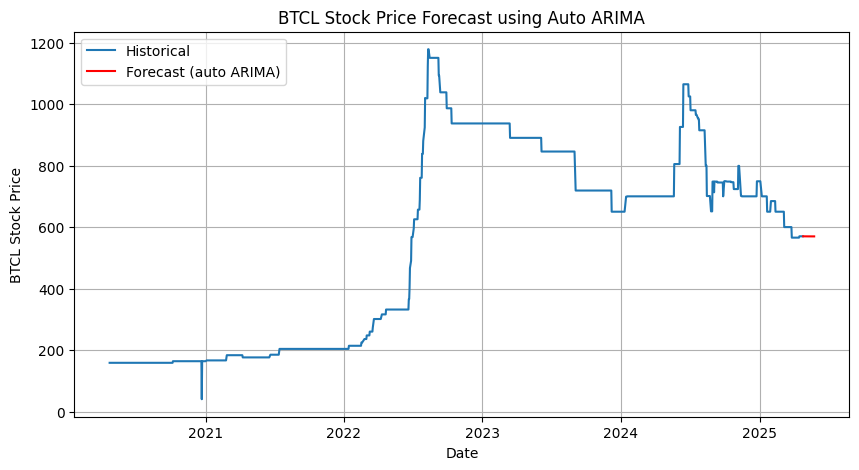

           Date  ARIMA_Predicted_BTCL
1230 2025-04-26            569.943975
1231 2025-04-27            569.949978
1232 2025-04-28            569.911709
1233 2025-04-29            569.907740
1234 2025-04-30            569.880860
1235 2025-05-01            569.872502
1236 2025-05-02            569.852450
1237 2025-05-03            569.842542
1238 2025-05-04            569.826809
1239 2025-05-05            569.816755
1240 2025-05-06            569.803932
1241 2025-05-07            569.794391
1242 2025-05-08            569.783656
1243 2025-05-09            569.774904
1244 2025-05-10            569.765756
1245 2025-05-11            569.757874
1246 2025-05-12            569.749990
1247 2025-05-13            569.742966
1248 2025-05-14            569.736122
1249 2025-05-15            569.729902
1250 2025-05-16            569.723935
1251 2025-05-17            569.718446
1252 2025-05-18            569.713230
1253 2025-05-19            569.708397
1254 2025-05-20            569.703830
1255 2025-05

In [46]:


# --- Step 1: Fit auto ARIMA model
auto_model = auto_arima(
    daily_df['BTCL'],
    seasonal=False,      # Set to True if you expect seasonality
    stepwise=True,       # Efficient search
    trace=True           # Optional: print search progress
)

print("Best ARIMA order found:", auto_model.order)

# --- Step 2: Fit final model using best order from auto_arima
model = ARIMA(daily_df['BTCL'], order=auto_model.order)
model_fit = model.fit()

# --- Step 3: Forecast next 30 days
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# --- Step 4: Create future date index
last_date = daily_df.index[-1]
forecast_dates = [last_date + timedelta(days=i) for i in range(1, forecast_steps + 1)]

# --- Step 5: Plot results
plt.figure(figsize=(10, 5))
plt.plot(daily_df.index, daily_df['BTCL'], label='Historical')
plt.plot(forecast_dates, forecast, color='red', label='Forecast (auto ARIMA)')
plt.title("BTCL Stock Price Forecast using Auto ARIMA")
plt.xlabel("Date")
plt.ylabel("BTCL Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# --- Optional: Forecast DataFrame
forecast_df = pd.DataFrame({'Date': forecast_dates, 'ARIMA_Predicted_BTCL': forecast})
print(forecast_df)



In [51]:
# Use only 'Close' price for modeling, .reshape(-1, 1) converts a 1D array to 2D with one column.
prices = daily_df['BTCL'].values.reshape(-1, 1)

# MinMaxScaler class from scikit-learn's preprocessing module Normalizes the prices in [0, 1] range
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

#Displaying the normalised Data
print("Min value after scaling:", scaled_prices.min())
print("Max value after scaling:", scaled_prices.max())
print(scaled_prices)

# Create sliding window features
#For each day, it: X (Input): Stores the past window_size days (e.g., 60 days) as a "window." y (Target): Stores the next day's price (what we want to predict).

def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_dataset(scaled_prices, window_size)

# Reshape for LSTM input: [samples, time steps, features] since LSTMs (and most deep learning models for sequences) require input in 3 dimensions:
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split 80% Training: Used to teach the model. 20% Testing: Used to check if the model predicts well on unseen data.
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model with Input layer first
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),  # Explicit Input layer
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(1)
])

model.compile(optimizer=Adam(), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)



Min value after scaling: 0.0
Max value after scaling: 1.0
[[0.10403401]
 [0.10403401]
 [0.10403401]
 ...
 [0.46549619]
 [0.46549619]
 [0.46549619]]
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - loss: 0.0665 - val_loss: 0.0039
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 9.6501e-04 - val_loss: 0.0020
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 9.2831e-04 - val_loss: 0.0020
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - loss: 6.9244e-04 - val_loss: 0.0018
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 7.1561e-04 - val_loss: 0.0017
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - loss: 7.0078e-04 - val_loss: 0.0014
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - loss: 5.0665e-04 - val_loss: 0.0021
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - loss: 5.7674e-04 - val_loss: 0.0013
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/s

In [53]:

# After training the model, you can predict both on training and testing sets
# Predict on training data (y_train)
train_pred = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred.reshape(-1, 1))

# Predict on testing data (y_test)
test_pred = model.predict(X_test)
test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))

# Inverse scale the actual values for training and testing sets
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create dates for training and testing periods
train_dates = daily_df['DateTime'].values[window_size:split+window_size]
test_dates = daily_df['DateTime'].values[split+window_size:]

# Combine training and testing results
train_results = pd.DataFrame({
    'Date': train_dates,
    'Actual Price': actual_train.flatten(),
    'Predicted Price': train_pred.flatten()
})

test_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': actual_test.flatten(),
    'Predicted Price': test_pred.flatten()
})

# Concatenate both
full_results = pd.concat([train_results, test_results])

# Display the combined result (actual vs predicted)
print(full_results)

# Plot the actual vs predicted prices using matplotlib
plt.figure(figsize=(14,6))
plt.plot(full_results['Date'], full_results['Actual Price'], label='Actual Price', color='blue')
plt.plot(full_results['Date'], full_results['Predicted Price'], label='Predicted Price', linestyle='dashed', color='red')
plt.title('BTCL Stock Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


KeyError: 'DateTime'